# Linear Regression and Model Selection on Advertising Data
Let's take a look at some advertising data, and then fill in the missing code using the provided hints and answer the questions in 1-2 sentences (Each ... indicates missing code or answer).

What are the **features**?
- TV: advertising dollars spent on TV for a single product in a given market (in thousands of dollars)
- Radio: advertising dollars spent on Radio 1
- Radio 2: advertising dollars spent on Radio 2
- Newspaper: advertising dollars spent on Newspaper
- Area: the location

What is the **response**?
- Sales: sales of a single product in a given market (in thousands of widgets)

There are 200 **observations**, and thus 200 markets in the dataset.

In [2]:
# imports
import pandas as pd
import numpy as np

##fill in the missing code to read data into a DataFrame using read_csv in pandas package
data = pd.read_csv('Advertising.csv')
data = data.dropna()
data.head()

,Unnamed: 0,TV,radio,radio_2,newspaper,area,sales
0,1,230.1,37.8,75.6,69.2,rural,22.1
1,2,44.5,39.3,78.6,45.1,urban,10.4
2,3,17.2,45.9,91.8,69.3,rural,9.3
3,4,151.5,41.3,82.6,58.5,urban,18.5
4,5,180.8,10.8,21.6,58.4,suburban,12.9


## Fitting the data to a Linear model (4 pts)
Let's try to fitting a linear regression model immediately to the given dataset

In [3]:
from sklearn.linear_model import LinearRegression

##fill in the feature list
feature_cols = ['TV', 'radio', 'radio_2', 'newspaper', 'area']
X = data[feature_cols].values
y = data.sales.values

## instantiate a Linear Regression model and fit to the data
model = LinearRegression()
model.fit(X, y)

# print coefficients
print(feature_cols, model.coef_)

ValueError: could not convert string to float: 'rural'

**Question**: What is the output of this first attempt to fit a Linear Regression model? Explain the output in 1-2 sentences.

***The model fails because there are non-numeric values included.  The field 'area' cannot be interpreted numerically, and therefore a linear regression is impossible without data preparation***

## Handling Categorical Features via One-Hot Encoding (4 pts)

We have to represent **area** numerically, but we can't simply code it as 0=rural, 1=suburban, 2=urban because that would imply an **ordered relationship** between suburban and urban (and thus urban is somehow "twice" the suburban category).

**Question:** How many variables need to be created and why? 

***At a minimum, only two variables are needed, in this case we can use Suburban, and urban.  When both of these are 0, it will represent rural areas.***

***However for this case, we will use three variables: area_rural, area_suburban, and area_urban***

**Question:** Intepret the encoding

- **rural** is coded as: **area_rural(1) area_suburban(0) area_urban(0)**
- **suburban** is coded as: **area_rural(0) area_suburban(1) area_urban(0)**
- **urban** is coded as: **area_rural(0) area_suburban(0) area_urban(1)**

In [4]:
## create three dummy variables using get_dummies, then exclude the first dummy column
area_dummies = pd.get_dummies(data.area, prefix='area')

# concatenate the dummy variable columns onto the original DataFrame (axis=0 means rows, axis=1 means columns)
data = pd.concat([data, area_dummies], axis=1)
data.head()

,Unnamed: 0,TV,radio,radio_2,newspaper,area,sales,area_rural,area_suburban,area_urban
0,1,230.1,37.8,75.6,69.2,rural,22.1,1,0,0
1,2,44.5,39.3,78.6,45.1,urban,10.4,0,0,1
2,3,17.2,45.9,91.8,69.3,rural,9.3,1,0,0
3,4,151.5,41.3,82.6,58.5,urban,18.5,0,0,1
4,5,180.8,10.8,21.6,58.4,suburban,12.9,0,1,0


Let's include the new dummy variables in the model:

In [5]:
## your new list of features
feature_cols = ['TV', 'radio', 'radio_2', 'newspaper', 'area_rural', 'area_suburban',
                'area_urban']
X = data[feature_cols].values
from sklearn import preprocessing

## Min max feature scaling using MinMaxScaler from sklearn
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(X)
X = min_max_scaler.transform(X)

## instantiate, fit
model = LinearRegression()
model.fit(X, y)

# print coefficients
#print(feature_cols, model.coef_)
list(zip(feature_cols, model.coef_))

[('TV', 13.543739378660407),
 ('radio', 4.652897200498303),
 ('radio_2', 4.65289720049832),
 ('newspaper', -0.115763521536425),
 ('area_rural', -0.0452105562674987),
 ('area_suburban', -0.16310085190900686),
 ('area_urban', 0.2083114081764963)]

**Question:** Holding all other variables fixed, how do we interpret the coefficients of dummy variables?
- Being a **suburban** area is associated with an average ***16.3% decrease in sales***
- Being an **urban** area is associated with an average ***20.8% increase in sales***

**Question:** What are the coefficients of radio and radio_2 features are look like? How does it possibly happen (1-2 sentences)?

***Radio and Radio_2 both have the same coefficient.  Since radio is exactly 1/2 of radio_2, these features perfectly correlated. The model may attempt to account for this by making their coefficients the same value. ***

## Handling Collinearity using VIF (4 pts)

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

## use variance_inflation_factor to compute VIF scores for the features 
vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

print(vif)

[1.0056448886982596, 1.1526097040655914, 1.1471311872820649, 2.7812685984480585, 3.1449780274265877, 2.8983810001513888]


**Question:** Based on the VIF values, what features are collinear and what features can we remove to elimiate collinearity?

***Radio and Radio_2 are collinear, we can remove one to eliminate the collinearity***

Recompute VIF scores after removing that feature

In [9]:
## Your new list of features after removing collinear features
feature_cols = ['TV', 'radio', 'newspaper', 'area_rural', 'area_suburban',
                'area_urban']
X = data[feature_cols].values

## Min max feature scaling
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(X)
X = min_max_scaler.transform(X)

## Compute VIF scores for all remaining features
vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

print(vif)

[1.0056448886982596, 1.1526097040655914, 1.1471311872820649, 2.7812685984480585, 3.1449780274265877, 2.8983810001513888]


**Question:** How do the VIF scores for these fetures look like?

***The VIF scores are now all within reasonable ranges*** 

## Handling Ourliers (4 pts)
Let's try to identify ourliers from our dataset using residual plot and seaborn package

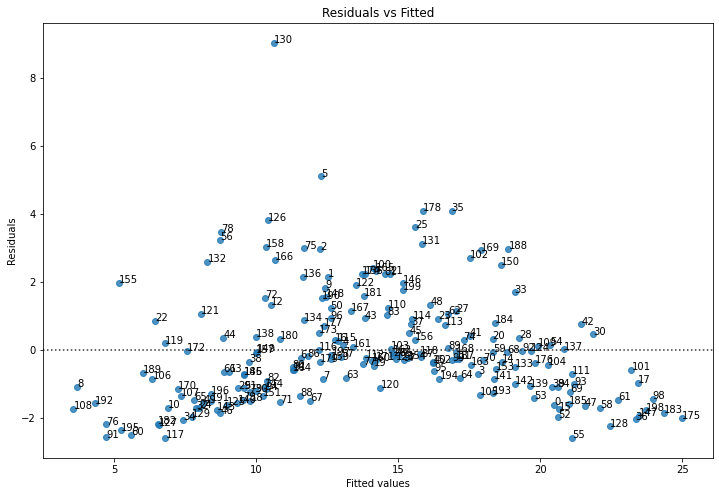

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

## instantiate, fit a linear regression model
model = LinearRegression()
model.fit(X, y)

## compute predicted values and residuals
y_pred = model.predict(X)
y_resid = y_pred - y 

plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)

## use residplot from seaborn to draw the residual plot
plot_lm_1.axes[0] = sns.residplot(x=y_pred,y=y_resid)

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

# annotations
for i in range(len(y)):
    plot_lm_1.axes[0].annotate(i, 
                               xy=(y_pred[i], 
                                   y_resid[i]));

**Question:** Find the point with highest residual and remove it from the data. Retrain the model and draw the residual plot again to confirm that the outlier has been removed

In [71]:
mask = ~(abs(y_resid) > 6)

X1 = X[mask!=True,:]
print(mask)


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

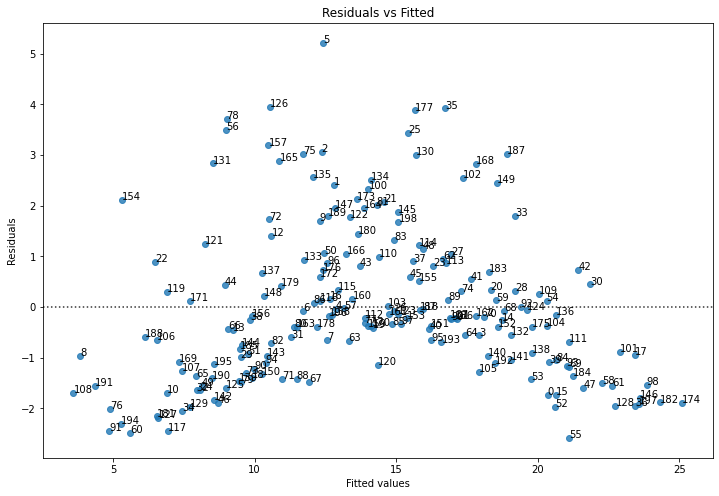

In [12]:
## remove point with highest residual from our data
mask = ~(abs(y_resid) > 6)

X = X[mask,:]
y = y[mask]

## train another linear regression model
model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)
y_resid = y_pred - y

plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)

## use residplot from seaborn to draw the residual plot
plot_lm_1.axes[0] = sns.residplot(x=y_pred,y=y_resid)

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

# annotations
for i in range(len(y)):
    plot_lm_1.axes[0].annotate(i, 
                               xy=(y_pred[i], 
                                   y_resid[i]));

## Linear Regression and GridSearchCV Model Selection in scikit-learn (4 pts)

Let's fit a Linear Regression model with ridge regularization and do model selection to select regularization constant. Fill in the missing code using the hints

In [45]:
# follow the usual sklearn pattern: import, instantiate, fit
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

kcv = KFold(n_splits=5, shuffle=True)
parameters = {'alpha':np.logspace(-3, 3, 7)}
model = Ridge()
score = 0

# Evaluate model by 5 fold cross validation
for train_index, test_index in kcv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    ## Use GridSearchCV to select regularization constant
    cmodel = GridSearchCV(model, parameters, cv=10, n_jobs = -2, scoring = 'neg_mean_squared_error', return_train_score=True) 
    cmodel.fit(X_train, y_train.ravel())
    
    ## Train Ridge on traning data using the selected regularization constant
    model = Ridge(alpha = cmodel.best_score_)
    model.fit(X_train, y_train)
    
    score += model.score(X_test, y_test)

print('Model score', score/5)

Model score 0.8290352286078327
